In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
inspector = inspect(engine)
stations_cols = inspector.get_columns("station")
print("Hawaii_Stations Column Types:")
print("-----------------------------")
for j in stations_cols:
    print(j["name"], j["type"])


Hawaii_Stations Column Types:
-----------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
measure_cols = inspector.get_columns("measurement")
print("Hawaii_Measurements Column Types:")
print("---------------------------------")
for i in measure_cols:
    print(i["name"], i["type"])

Hawaii_Measurements Column Types:
---------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


__Step 1: Climate Analysis and Exploration__

- Part A: Precipitation Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_given_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last given date in data set: {last_given_date[0]}")
one_yr_ago_from_last_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"1 year ago from last data point: {one_yr_ago_from_last_date}")

Last given date in data set: 2017-08-23
1 year ago from last data point: 2016-08-23


In [10]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date,Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2016-08-23").\
                    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns = ["Date", "Prcp"])
new_prcp_df = prcp_df.dropna(how="any")

# Sort the dataframe by date
new_prcp_df = new_prcp_df.sort_values(by = "Date", ascending = True)
new_prcp_df

Date  Prcp
0     2016-08-23  0.00
1     2016-08-23  0.15
2     2016-08-23  0.05
4     2016-08-23  0.02
5     2016-08-23  1.79
...          ...   ...
2223  2017-08-22  0.00
2227  2017-08-23  0.00
2228  2017-08-23  0.08
2226  2017-08-23  0.00
2229  2017-08-23  0.45

[2021 rows x 2 columns]

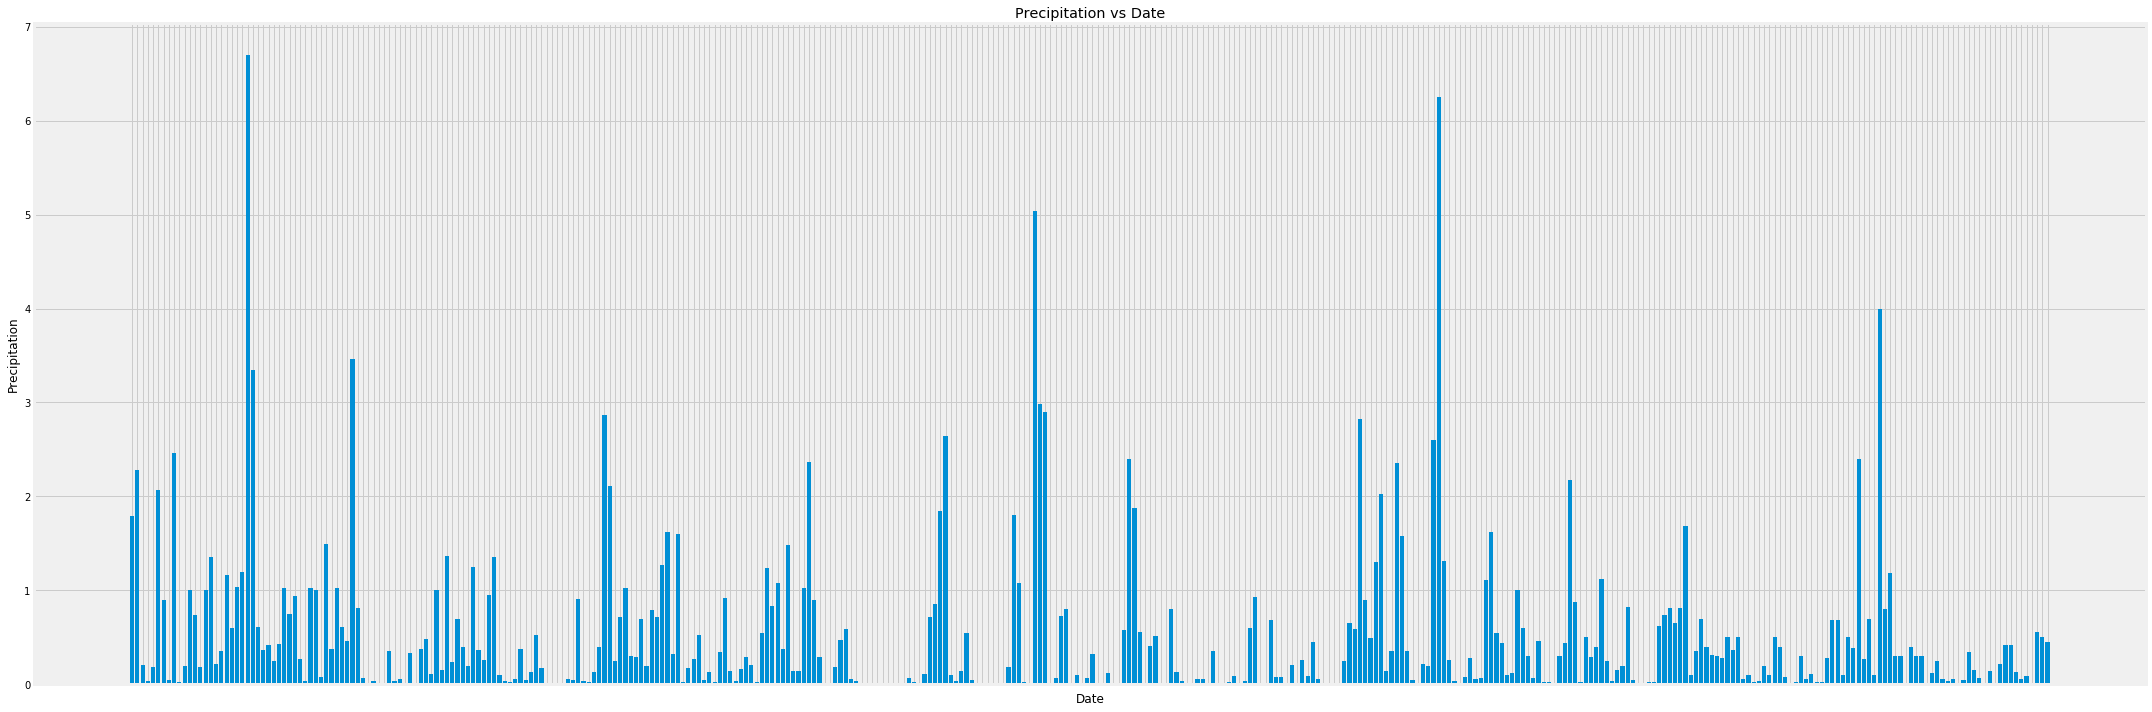

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (30,10))

ax.bar(new_prcp_df["Date"], new_prcp_df["Prcp"], align = "center")

ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.set_title("Precipitation vs Date")
ax.set_xticklabels([])

ax.grid(True)

fig.tight_layout()
fig.savefig("Precipitation Analysis.png")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new_prcp_df.describe()

Prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

- Part B: Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
print(f"There are {station_count} stations ")

There are [(9,)] stations 


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = Measurement.station
station_count = (stations, func.count(Measurement.id))

active_stations = session.query(*station_count).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_temp = func.max(Measurement.tobs)
lowest_temp = func.min(Measurement.tobs)
avg_temp = func.avg(Measurement.tobs)
session.query(lowest_temp, avg_temp).filter(Measurement.station == "USC00519281").all()

[(54.0, 71.66378066378067)]

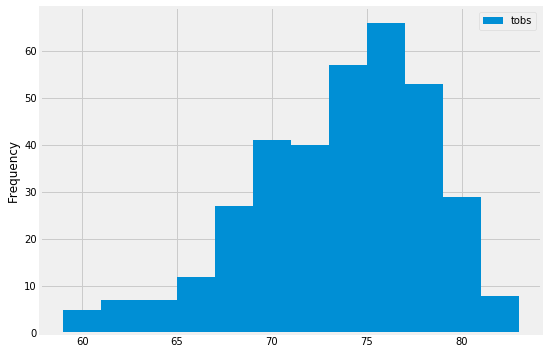

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
temps_df = pd.DataFrame(temps, columns=["Station","tobs"])
temps_df.set_index("Station")

temps_df.plot(kind= 'hist', bins=12, figsize = (8,6))
tobs = mpatches.Patch(label="tobs")
plt.legend(handles=[tobs])

plt.savefig("Station Analysis.png")
plt.show()

- Temperature Analysis

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_temps = calc_temps('2016-09-10', '2016-09-20')
my_trip_temps

[(70.0, 77.17391304347827, 83.0)]

In [20]:
#Created a DataFrame for my_trip_temps:
my_trip_temp_df = pd.DataFrame(my_trip_temps, columns = ["TMIN", "TAVG", "TMAX"])
my_trip_temp_df

TMIN       TAVG  TMAX
0  70.0  77.173913  83.0

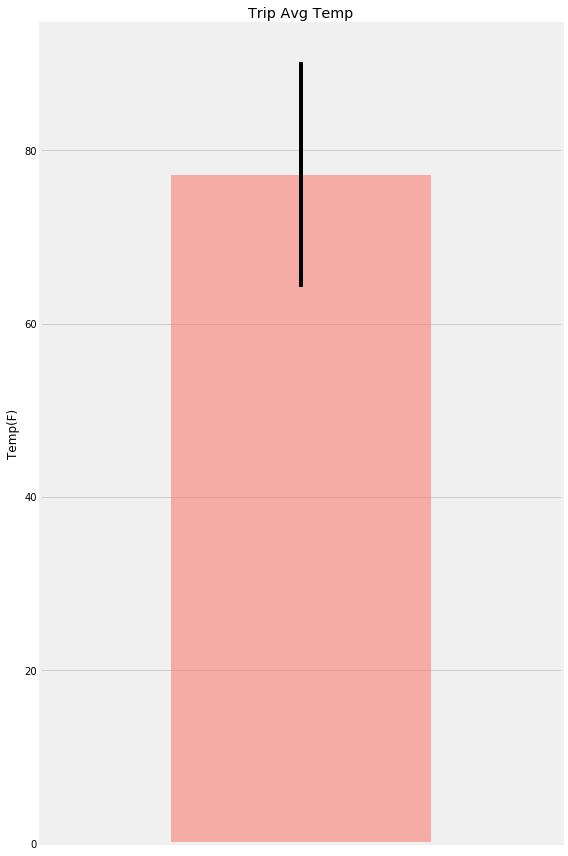

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_temp_df.plot.bar(y="TAVG", yerr=(my_trip_temp_df["TMAX"] - my_trip_temp_df["TMIN"]),
                         figsize=(8,12), color="salmon", alpha=0.6)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")

plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Trip Avg Temp.png")
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
weather_station_rf = session.query(Station.station, Station.name, 
                                   Station.latitude, Station.longitude, 
                                   Station.elevation, Measurement.prcp).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2016-09-10').\
filter(Measurement.date <= '2016-09-20').\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print("total amount of rainfall per weather station:")
print("----------------------------------------------")
print(weather_station_rf)

total amount of rainfall per weather station:
----------------------------------------------
[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.16), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.14), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.09), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.01), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]